## LSTM AutoEncoders :

References : <br>  https://github.com/VivekPa/AIAlpha  <br>  https://medium.com/analytics-vidhya/using-machine-learning-to-predict-stock-prices-c4d0b23b029a  <br>  https://github.com/borisbanushev/stockpredictionai#thedata  <br>  https://github.com/borisbanushev/stockpredictionai  <br>  https://towardsdatascience.com/aifortrading-2edd6fac689d  <br>  https://pywavelets.readthedocs.io/en/latest/ref/dwt-discrete-wavelet-transform.html  <br>  https://github.com/zhiruiwang/LSTM_stock_price_prediction/blob/master/code.ipynb  <br>  https://github.com/amunategui/CVAE-Financial-Anomaly-Detection/blob/master/Financial%20Compliance%20and%20Fraud%20Detection%20with%20Conditional%20Variational%20Autoencoders%20(CVAE)%20and%20Tensorflow.ipynb  <br>  https://amunategui.github.io/cvae-in-finance/index.html  <br>  https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0180944

## Import Data from Yahoo Finance fr Apple Inc.

Here we will download the financial data for Apple Inc. Stock Prices for the Duration of 1st January 2013 to 1st December 2018 from Yahoo Finance Stock Data and convert it into a pandas DataFrame for furhter analysis using LSTM Autoencoders.

In [2]:
import pandas_datareader.data as pdr
import fix_yahoo_finance as fix
fix.pdr_override()


class GetData:
    def __init__(self, ticker, start, end):
        self.ticker = ticker
        self.start = start
        self.end = end

    # get stock data
    def get_stock_data(self):
        stock_data_AAPL = pdr.get_data_yahoo(self.ticker, self.start, self.end)
        stock_data_AAPL.to_csv("stock_data_AAPL.csv")

if __name__ == "__main__":
    data = GetData("AAPL", "2013-01-01", "2018-12-01")
data.get_stock_data()

[*********************100%***********************]  1 of 1 downloaded


Here we will use a date parser function for converting timestamps into dates for ease of use in the code.

In [3]:
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

## Import Libraries and Packages

In [4]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Import pandas .csv file and display its head

In [5]:
stock_data_AAPL = pd.read_csv('stock_data.csv', header=0, parse_dates=[0], date_parser=parser)
stock_data_AAPL.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,27.25,27.73,27.15,27.62,23.67,52899300
1,2013-01-03,27.63,27.65,27.16,27.25,23.35,48294400
2,2013-01-04,27.27,27.34,26.73,26.74,22.92,52521100
3,2013-01-07,26.77,26.88,26.64,26.69,22.87,37110400
4,2013-01-08,26.75,26.79,26.46,26.55,22.75,44703100


## Plot the Stock Market Graph for Apple Inc. for given duration

C:\Users\NEERAJ\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


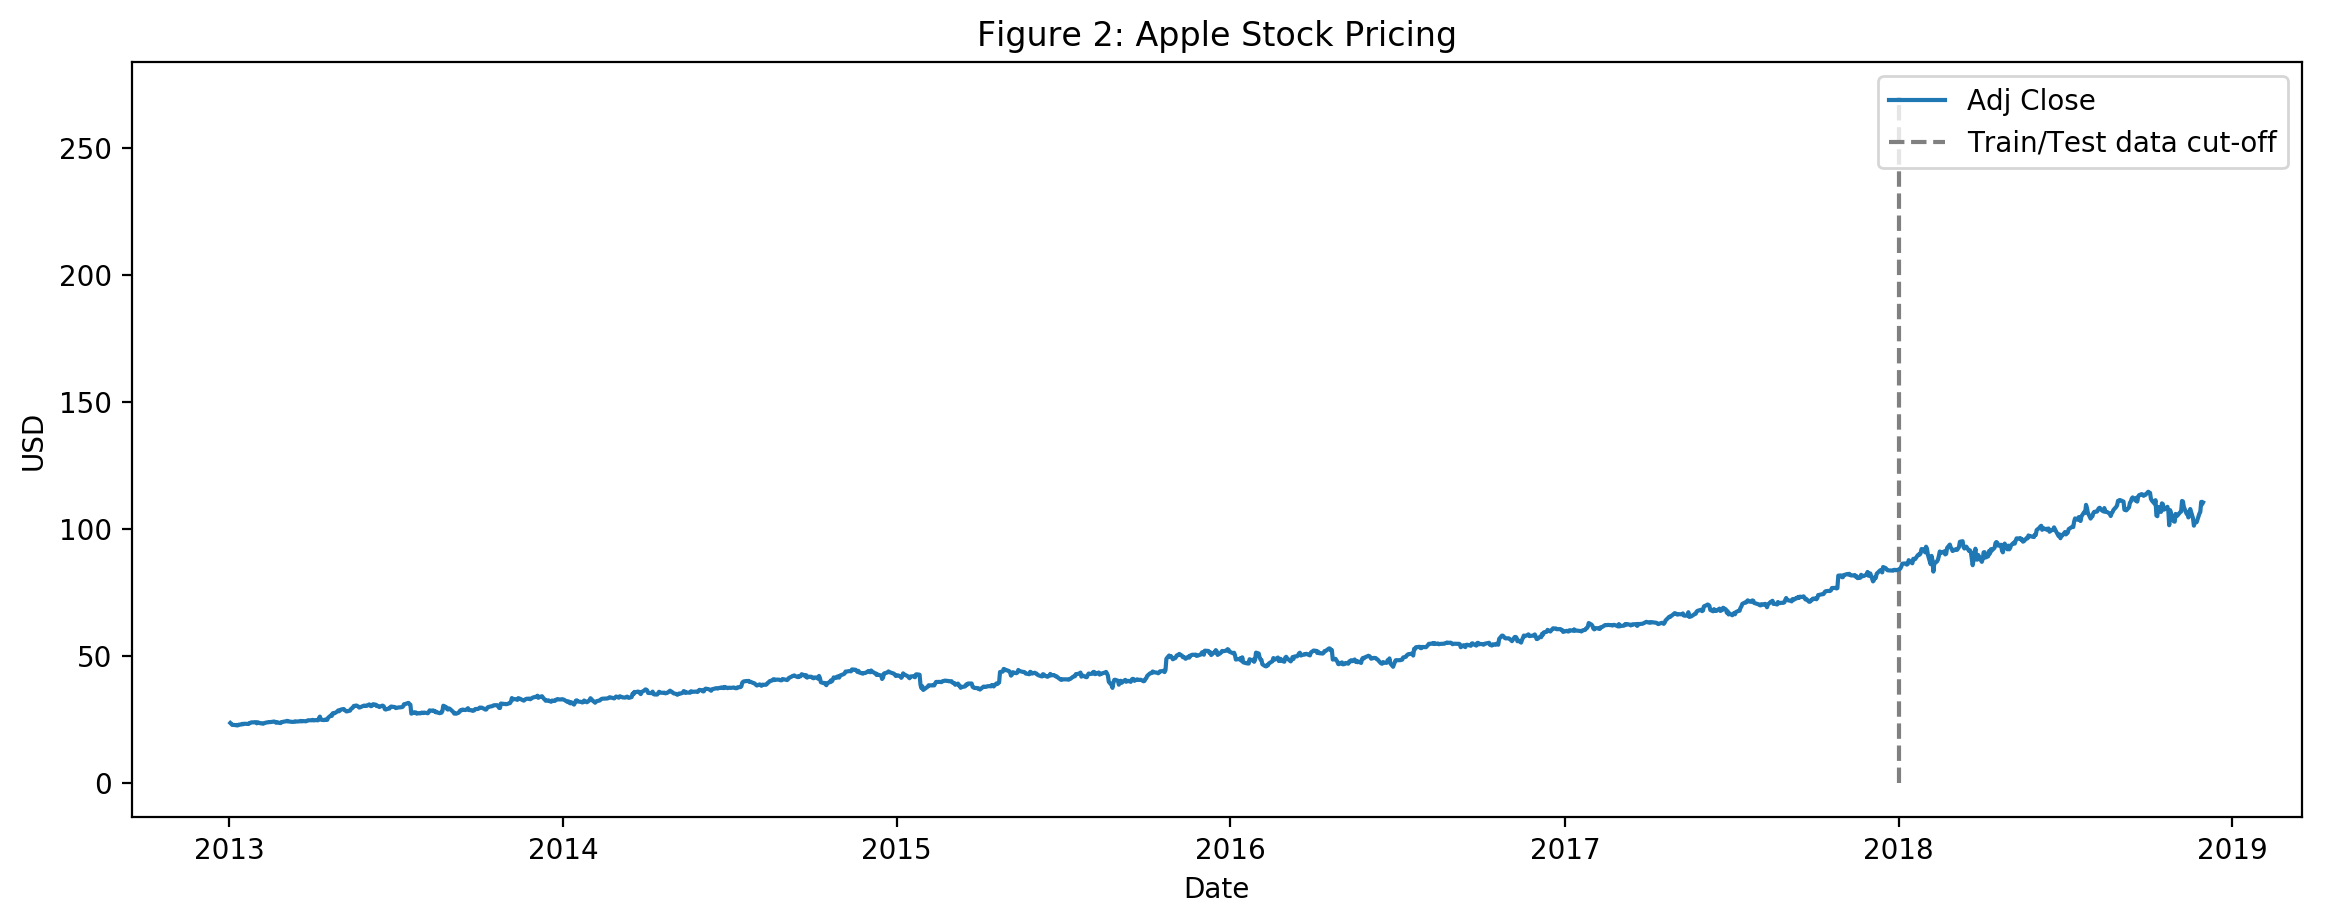

In [6]:
plt.figure(figsize=(14, 5), dpi=200)
plt.plot(stock_data_AAPL['Date'], stock_data_AAPL['Adj Close'])
plt.vlines(datetime.date(2018,1, 1), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: Apple Stock Pricing')
plt.legend()
plt.show()

## Analyze the number of days and split training and testing days

In [9]:
num_training_days = int(stock_data_AAPL.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    stock_data_AAPL.shape[0]-num_training_days))

Number of training days: 1043. Number of test days: 448.


## Analyze the Data using Fourier Transforms

In [10]:
data_FT = stock_data_AAPL[['Date', 'Adj Close']]

In [11]:
close_fft = np.fft.fft(np.asarray(data_FT['Adj Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

## Plot the Graph for Fourier Transforms

C:\Users\NEERAJ\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


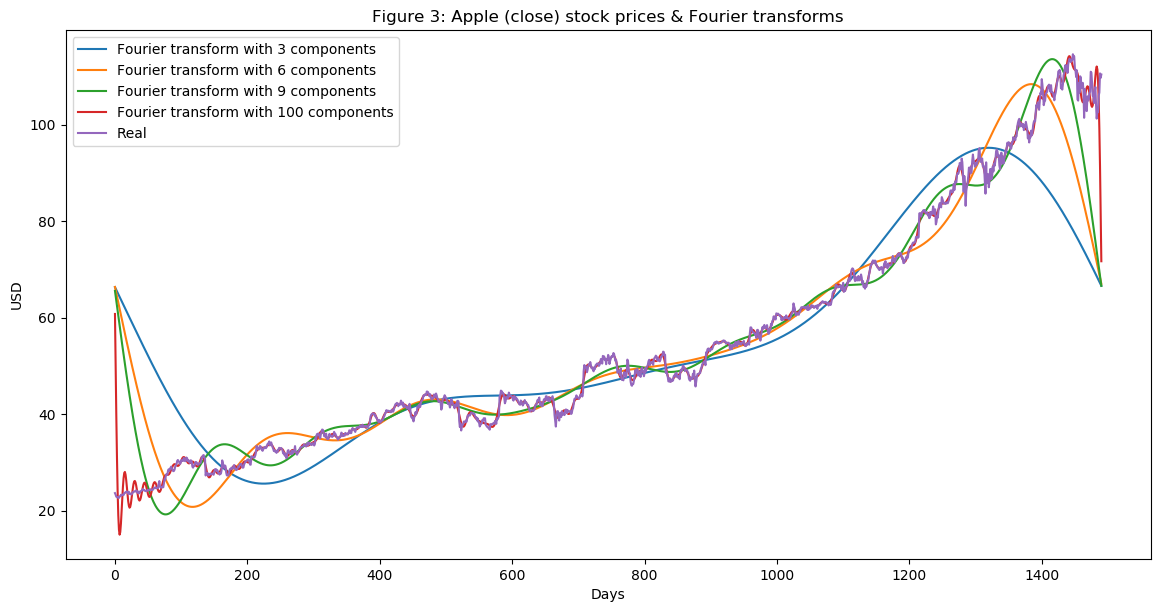

In [12]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['Adj Close'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Apple (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

## Plot the Components in the Fourier Transforms

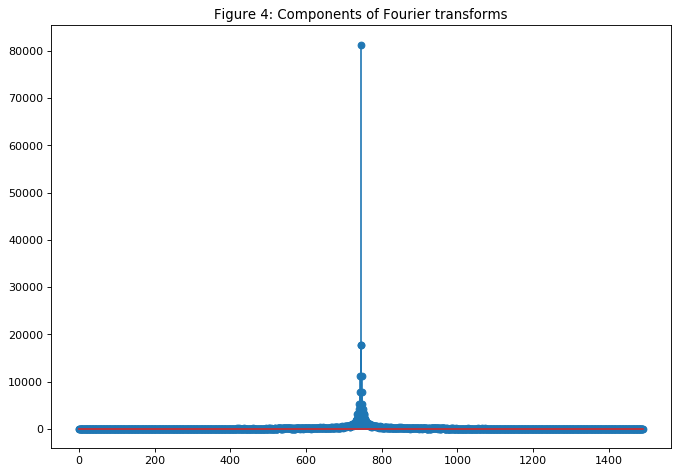

In [13]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

## Pre-process the Data and Wavelet Transforms

Here we will pre-process the data by splitting into traning and testing data and apply Wavelet Transforms to them for de-noising and preserving the time essence

In [15]:
import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt


class PreProcessing:
    def __init__(self, split, feature_split):
        self.split = split
        self.feature_split = feature_split
        self.stock_data = pd.read_csv("stock_data_AAPL.csv")

    # wavelet transform and create autoencoder data
    def make_wavelet_train(self):
        train_data = []
        test_data = []
        log_train_data = []
        for i in range((len(self.stock_data)//10)*10 - 11):
            train = []
            log_ret = []
            for j in range(1, 6):
                x = np.array(self.stock_data.iloc[i: i + 11, j])
                (ca, cd) = pywt.dwt(x, "haar")
                cat = pywt.threshold(ca, np.std(ca), mode="soft")
                cdt = pywt.threshold(cd, np.std(cd), mode="soft")
                tx = pywt.idwt(cat, cdt, "haar")
                log = np.diff(np.log(tx))*100
                macd = np.mean(x[5:]) - np.mean(x)
                # ma = np.mean(x)
                sd = np.std(x)
                log_ret = np.append(log_ret, log)
                x_tech = np.append(macd*10, sd)
                train = np.append(train, x_tech)
            train_data.append(train)
            log_train_data.append(log_ret)
        trained = pd.DataFrame(train_data)
        trained.to_csv("preprocessing/indicators_AAPL.csv")
        log_train = pd.DataFrame(log_train_data, index=None)
        log_train.to_csv("preprocessing/log_train_AAPL.csv")
        # auto_train = pd.DataFrame(train_data[0:800])
        # auto_test = pd.DataFrame(train_data[801:1000])
        # auto_train.to_csv("auto_train.csv")
        # auto_test.to_csv("auto_test.csv")
        rbm_train = pd.DataFrame(log_train_data[0:int(self.split*self.feature_split*len(log_train_data))], index=None)
        rbm_train.to_csv("preprocessing/rbm_train_AAPL.csv")
        rbm_test = pd.DataFrame(log_train_data[int(self.split*self.feature_split*len(log_train_data))+1:
                                               int(self.feature_split*len(log_train_data))])
        rbm_test.to_csv("preprocessing/rbm_test_AAPL.csv")
        for i in range((len(self.stock_data) // 10) * 10 - 11):
            y = 100*np.log(self.stock_data.iloc[i + 11, 5] / self.stock_data.iloc[i + 10, 5])
            test_data.append(y)
        test = pd.DataFrame(test_data)
        test.to_csv("preprocessing/test_data_AAPL.csv")

    def make_test_data(self):
        test_stock = []
        # stock_data_test = pd.read_csv("stock_data_test.csv", index_col=0)

        for i in range((len(self.stock_data) // 10) * 10 - 11):
            l = self.stock_data.iloc[i+11, 5]
            test_stock.append(l)
            test = pd.DataFrame(test_stock)
            test.to_csv("preprocessing/test_stock_AAPL.csv")

        stock_test_data = np.array(test_stock)[int(self.feature_split*len(test_stock) +
                                               self.split*(1-self.feature_split)*len(test_stock)):]
        stock = pd.DataFrame(stock_test_data, index=None)
        stock.to_csv("stock_data_test_AAPL.csv")

        # print(train_data[1:5])
        # print(test_data[1:5])
        # plt.plot(train_data[1])
        # plt.show()


if __name__ == "__main__":
    preprocess = PreProcessing(0.8, 0.25)
    preprocess.make_wavelet_train()
    preprocess.make_test_data()


## Build And Train the Stacked AutoEncoder 

In [16]:
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
import pandas as pd
import numpy as np


class AutoEncoder:
    def __init__(self, encoding_dim):
        self.encoding_dim = encoding_dim

    def build_train_model(self, input_shape, encoded1_shape, encoded2_shape, decoded1_shape, decoded2_shape):
        input_data = Input(shape=(1, input_shape))

        encoded1 = Dense(encoded1_shape, activation="relu", activity_regularizer=regularizers.l2(0))(input_data)
        encoded2 = Dense(encoded2_shape, activation="relu", activity_regularizer=regularizers.l2(0))(encoded1)
        encoded3 = Dense(self.encoding_dim, activation="relu", activity_regularizer=regularizers.l2(0))(encoded2)
        decoded1 = Dense(decoded1_shape, activation="relu", activity_regularizer=regularizers.l2(0))(encoded3)
        decoded2 = Dense(decoded2_shape, activation="relu", activity_regularizer=regularizers.l2(0))(decoded1)
        decoded = Dense(input_shape, activation="sigmoid", activity_regularizer=regularizers.l2(0))(decoded2)

        autoencoder = Model(inputs=input_data, outputs=decoded)

        encoder = Model(input_data, encoded3)

        # Now train the model using data we already preprocessed
        autoencoder.compile(loss="mean_squared_error", optimizer="adam")

        train = pd.read_csv("preprocessing/rbm_train_AAPL.csv", index_col=0)
        ntrain = np.array(train)
        train_data = np.reshape(ntrain, (len(ntrain), 1, input_shape))

        # print(train_data)
        # autoencoder.summary()
        autoencoder.fit(train_data, train_data, epochs=1000)

        encoder.save("models/encoder_AAPL.h5")

        test = pd.read_csv("preprocessing/rbm_test_AAPL.csv", index_col=0)
        ntest = np.array(test)
        test_data = np.reshape(ntest, (len(ntest), 1, 55))

        print(autoencoder.evaluate(test_data, test_data))
        # pred = np.reshape(ntest[1], (1, 1, 75))
        # print(encoder.predict(pred))

        log_train = pd.read_csv("preprocessing/log_train_AAPL.csv", index_col=0)
        coded_train = []
        for i in range(len(log_train)):
            data = np.array(log_train.iloc[i, :])
            values = np.reshape(data, (1, 1, 55))
            coded = encoder.predict(values)
            shaped = np.reshape(coded, (20,))
            coded_train.append(shaped)

        train_coded = pd.DataFrame(coded_train)
        train_coded.to_csv("features/autoencoded_data_AAPL.csv")


if __name__ == "__main__":
    autoencoder = AutoEncoder(20)
autoencoder.build_train_model(55, 40, 30, 30, 40)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/1000
295/295 [==============================] - 5s 16ms/step - loss: 2.3439
Epoch 2/1000
295/295 [==============================] - 0s 112us/step - loss: 2.3080
Epoch 3/1000
295/295 [==============================] - 0s 108us/step - loss: 2.2601
Epoch 4/1000
295/295 [==============================] - 0s 108us/step - loss: 2.1878
Epoch 5/1000
295/295 [==============================] - 0s 105us/step - loss: 2.1086
Epoch 6/1000
295/295 [==============================] - 0s 98us/step - loss: 2.0497
Epoch 7/1000
295/295 [==============================] - 0s 101us/step - loss: 2.0102
Epoch 8/1000
295/295 [==============================] - 0s 101us/step - loss: 1.9867
Epoch 9/1000
295/295 [==============================] - 0s 98us/step - loss: 1.9674
Epoch 10/1000
295/295 [==============================] - 0s 118us/step - loss: 1.9435
Epoch 11/1000
295/295 [=========

295/295 [==============================] - 0s 95us/step - loss: 1.6395
Epoch 91/1000
295/295 [==============================] - 0s 101us/step - loss: 1.6383
Epoch 92/1000
295/295 [==============================] - 0s 95us/step - loss: 1.6381
Epoch 93/1000
295/295 [==============================] - 0s 91us/step - loss: 1.6368
Epoch 94/1000
295/295 [==============================] - 0s 98us/step - loss: 1.6364
Epoch 95/1000
295/295 [==============================] - 0s 101us/step - loss: 1.6357
Epoch 96/1000
295/295 [==============================] - 0s 98us/step - loss: 1.6360
Epoch 97/1000
295/295 [==============================] - 0s 95us/step - loss: 1.6351
Epoch 98/1000
295/295 [==============================] - 0s 98us/step - loss: 1.6351
Epoch 99/1000
295/295 [==============================] - 0s 98us/step - loss: 1.6343
Epoch 100/1000
295/295 [==============================] - 0s 98us/step - loss: 1.6341
Epoch 101/1000
295/295 [==============================] - 0s 95us/step - los

295/295 [==============================] - 0s 98us/step - loss: 1.6110
Epoch 186/1000
295/295 [==============================] - 0s 105us/step - loss: 1.6109
Epoch 187/1000
295/295 [==============================] - 0s 98us/step - loss: 1.6109
Epoch 188/1000
295/295 [==============================] - 0s 91us/step - loss: 1.6108
Epoch 189/1000
295/295 [==============================] - 0s 95us/step - loss: 1.6107
Epoch 190/1000
295/295 [==============================] - 0s 91us/step - loss: 1.6101
Epoch 191/1000
295/295 [==============================] - 0s 95us/step - loss: 1.6100
Epoch 192/1000
295/295 [==============================] - 0s 98us/step - loss: 1.6099
Epoch 193/1000
295/295 [==============================] - 0s 95us/step - loss: 1.6098
Epoch 194/1000
295/295 [==============================] - 0s 95us/step - loss: 1.6097
Epoch 195/1000
295/295 [==============================] - 0s 91us/step - loss: 1.6100
Epoch 196/1000
295/295 [==============================] - 0s 91us/st

295/295 [==============================] - 0s 95us/step - loss: 1.6026
Epoch 280/1000
295/295 [==============================] - 0s 101us/step - loss: 1.6027
Epoch 281/1000
295/295 [==============================] - 0s 101us/step - loss: 1.6021
Epoch 282/1000
295/295 [==============================] - 0s 98us/step - loss: 1.6019
Epoch 283/1000
295/295 [==============================] - 0s 95us/step - loss: 1.6028
Epoch 284/1000
295/295 [==============================] - 0s 98us/step - loss: 1.6024
Epoch 285/1000
295/295 [==============================] - 0s 91us/step - loss: 1.6024
Epoch 286/1000
295/295 [==============================] - 0s 95us/step - loss: 1.6021
Epoch 287/1000
295/295 [==============================] - 0s 95us/step - loss: 1.6019
Epoch 288/1000
295/295 [==============================] - 0s 95us/step - loss: 1.6019
Epoch 289/1000
295/295 [==============================] - 0s 101us/step - loss: 1.6025
Epoch 290/1000
295/295 [==============================] - 0s 105us

Epoch 374/1000
295/295 [==============================] - 0s 108us/step - loss: 1.6022
Epoch 375/1000
295/295 [==============================] - 0s 98us/step - loss: 1.6009
Epoch 376/1000
295/295 [==============================] - 0s 101us/step - loss: 1.5997
Epoch 377/1000
295/295 [==============================] - 0s 101us/step - loss: 1.5993
Epoch 378/1000
295/295 [==============================] - 0s 98us/step - loss: 1.5991
Epoch 379/1000
295/295 [==============================] - 0s 98us/step - loss: 1.5991
Epoch 380/1000
295/295 [==============================] - 0s 95us/step - loss: 1.5989
Epoch 381/1000
295/295 [==============================] - 0s 98us/step - loss: 1.5989
Epoch 382/1000
295/295 [==============================] - 0s 95us/step - loss: 1.5985
Epoch 383/1000
295/295 [==============================] - 0s 95us/step - loss: 1.5984
Epoch 384/1000
295/295 [==============================] - 0s 128us/step - loss: 1.5982
Epoch 385/1000
295/295 [==========================

295/295 [==============================] - 0s 91us/step - loss: 1.5970
Epoch 470/1000
295/295 [==============================] - 0s 98us/step - loss: 1.5970
Epoch 471/1000
295/295 [==============================] - 0s 95us/step - loss: 1.5972
Epoch 472/1000
295/295 [==============================] - 0s 91us/step - loss: 1.5976
Epoch 473/1000
295/295 [==============================] - 0s 91us/step - loss: 1.5972
Epoch 474/1000
295/295 [==============================] - 0s 91us/step - loss: 1.5971
Epoch 475/1000
295/295 [==============================] - 0s 91us/step - loss: 1.5968
Epoch 476/1000
295/295 [==============================] - 0s 88us/step - loss: 1.5969
Epoch 477/1000
295/295 [==============================] - 0s 95us/step - loss: 1.5967
Epoch 478/1000
295/295 [==============================] - 0s 91us/step - loss: 1.5968
Epoch 479/1000
295/295 [==============================] - 0s 88us/step - loss: 1.5968
Epoch 480/1000
295/295 [==============================] - 0s 91us/ste

295/295 [==============================] - 0s 91us/step - loss: 1.5955
Epoch 565/1000
295/295 [==============================] - 0s 91us/step - loss: 1.5955
Epoch 566/1000
295/295 [==============================] - 0s 88us/step - loss: 1.5957
Epoch 567/1000
295/295 [==============================] - 0s 98us/step - loss: 1.5960
Epoch 568/1000
295/295 [==============================] - 0s 91us/step - loss: 1.5961
Epoch 569/1000
295/295 [==============================] - 0s 91us/step - loss: 1.5959
Epoch 570/1000
295/295 [==============================] - 0s 88us/step - loss: 1.5955
Epoch 571/1000
295/295 [==============================] - 0s 95us/step - loss: 1.5959
Epoch 572/1000
295/295 [==============================] - 0s 91us/step - loss: 1.5955
Epoch 573/1000
295/295 [==============================] - 0s 91us/step - loss: 1.5958
Epoch 574/1000
295/295 [==============================] - 0s 91us/step - loss: 1.5957
Epoch 575/1000
295/295 [==============================] - 0s 91us/ste

295/295 [==============================] - 0s 91us/step - loss: 1.5946
Epoch 660/1000
295/295 [==============================] - 0s 95us/step - loss: 1.5947
Epoch 661/1000
295/295 [==============================] - 0s 91us/step - loss: 1.5945
Epoch 662/1000
295/295 [==============================] - 0s 91us/step - loss: 1.5949
Epoch 663/1000
295/295 [==============================] - 0s 91us/step - loss: 1.5949
Epoch 664/1000
295/295 [==============================] - 0s 98us/step - loss: 1.5962
Epoch 665/1000
295/295 [==============================] - 0s 91us/step - loss: 1.5954
Epoch 666/1000
295/295 [==============================] - 0s 91us/step - loss: 1.5955
Epoch 667/1000
295/295 [==============================] - 0s 91us/step - loss: 1.5951
Epoch 668/1000
295/295 [==============================] - 0s 91us/step - loss: 1.5948
Epoch 669/1000
295/295 [==============================] - 0s 91us/step - loss: 1.5949
Epoch 670/1000
295/295 [==============================] - 0s 91us/ste

295/295 [==============================] - 0s 101us/step - loss: 1.5944
Epoch 755/1000
295/295 [==============================] - 0s 112us/step - loss: 1.5940
Epoch 756/1000
295/295 [==============================] - 0s 98us/step - loss: 1.5940
Epoch 757/1000
295/295 [==============================] - 0s 98us/step - loss: 1.5951
Epoch 758/1000
295/295 [==============================] - 0s 95us/step - loss: 1.5948
Epoch 759/1000
295/295 [==============================] - 0s 101us/step - loss: 1.5944
Epoch 760/1000
295/295 [==============================] - 0s 101us/step - loss: 1.5942
Epoch 761/1000
295/295 [==============================] - 0s 101us/step - loss: 1.5940
Epoch 762/1000
295/295 [==============================] - 0s 98us/step - loss: 1.5940
Epoch 763/1000
295/295 [==============================] - 0s 122us/step - loss: 1.5937
Epoch 764/1000
295/295 [==============================] - 0s 118us/step - loss: 1.5936
Epoch 765/1000
295/295 [==============================] - ETA:

295/295 [==============================] - 0s 105us/step - loss: 1.5938
Epoch 849/1000
295/295 [==============================] - 0s 101us/step - loss: 1.5939
Epoch 850/1000
295/295 [==============================] - 0s 101us/step - loss: 1.5938
Epoch 851/1000
295/295 [==============================] - 0s 101us/step - loss: 1.5936
Epoch 852/1000
295/295 [==============================] - 0s 98us/step - loss: 1.5934
Epoch 853/1000
295/295 [==============================] - 0s 105us/step - loss: 1.5935
Epoch 854/1000
295/295 [==============================] - 0s 105us/step - loss: 1.5936
Epoch 855/1000
295/295 [==============================] - 0s 101us/step - loss: 1.5934
Epoch 856/1000
295/295 [==============================] - 0s 95us/step - loss: 1.5932
Epoch 857/1000
295/295 [==============================] - 0s 95us/step - loss: 1.5932
Epoch 858/1000
295/295 [==============================] - 0s 91us/step - loss: 1.5935
Epoch 859/1000
295/295 [==============================] - 0s 9

295/295 [==============================] - 0s 95us/step - loss: 1.5932
Epoch 944/1000
295/295 [==============================] - 0s 98us/step - loss: 1.5932
Epoch 945/1000
295/295 [==============================] - 0s 95us/step - loss: 1.5933
Epoch 946/1000
295/295 [==============================] - 0s 98us/step - loss: 1.5937
Epoch 947/1000
295/295 [==============================] - 0s 95us/step - loss: 1.5938
Epoch 948/1000
295/295 [==============================] - 0s 95us/step - loss: 1.5936
Epoch 949/1000
295/295 [==============================] - 0s 95us/step - loss: 1.5936
Epoch 950/1000
295/295 [==============================] - 0s 95us/step - loss: 1.5934
Epoch 951/1000
295/295 [==============================] - 0s 91us/step - loss: 1.5934
Epoch 952/1000
295/295 [==============================] - 0s 91us/step - loss: 1.5934
Epoch 953/1000
295/295 [==============================] - 0s 95us/step - loss: 1.5935
Epoch 954/1000
295/295 [==============================] - 0s 95us/ste

## Process the Data for LSTM Layers after AutoEncoder Layers

In [17]:
import numpy as np
import pandas as pd


class DataProcessing:
    def __init__(self, split, feature_split):
        self.split = split
        self.feature_split = feature_split
        # self.train = pd.read_csv("train_data.csv", index_col=0)
        # print(train.tail())
        self.test = pd.read_csv("preprocessing/test_data_AAPL.csv", index_col=0)
        # print(test.tail())
        self.test_stock = pd.read_csv("preprocessing/test_stock_AAPL.csv", index_col=0)
        # self.auto_train = pd.read_csv("features/autoencoded_corrected_data.csv", index_col=0)
        self.auto_train = pd.read_csv("features/autoencoded_data_AAPL.csv", index_col=0)
        # auto_train.drop([0, 14, 16], axis=1, inplace=True)
        # auto_train.to_csv("autoencoded_corrected_data.csv", index=None)

    def make_train_data(self):
        train_data = np.array(self.auto_train)[int(self.feature_split*len(self.auto_train))+1:
                                               int((1-self.feature_split)*self.split*len(self.auto_train))]
        train_data = pd.DataFrame(train_data, index=None)
        train_data.to_csv("features/autoencoded_train_data_AAPL.csv")

    def make_test_data(self):
        test_data = np.array(self.auto_train)[int((1-self.feature_split)*self.split*len(self.auto_train) +
                                                  self.feature_split*len(self.auto_train)+1):]
        test_data = pd.DataFrame(test_data, index=None)
        test_data.to_csv("features/autoencoded_test_data_AAPL.csv")

    def make_train_y(self):
        train_y = np.array(self.test)[int(self.feature_split*len(self.auto_train))+1:
                                      int((1-self.feature_split)*self.split*len(self.auto_train))]
        train_y = pd.DataFrame(train_y, index=None)
        train_y.to_csv("features/autoencoded_train_y_AAPL.csv")

    def make_test_y(self):
        test_y = np.array(self.test)[int((1-self.feature_split)*self.split*len(self.auto_train) +
                                         self.feature_split*len(self.auto_train))+1:]
        test_y = pd.DataFrame(test_y)
        test_y.to_csv("features/autoencoded_test_y_AAPL.csv")

    def make_stock_train_y(self):
        test_y = np.array(self.test_stock)[int(self.feature_split*len(self.auto_train))+1:
                                           int((1-self.feature_split)*self.split*len(self.auto_train))]
        test_y = pd.DataFrame(test_y, index=None)
        test_y.to_csv("features/nn_stock_train_y_AAPL.csv")

    def make_stock_test_y(self):
        test_y = np.array(self.test_stock)[int((1-self.feature_split)*self.split*len(self.auto_train))+1:]
        test_y = pd.DataFrame(test_y, index=None)
        test_y.to_csv("features/nn_stock_test_y_AAPL.csv")


if __name__ == "__main__":
    process = DataProcessing(0.8, 0.25)
    process.make_test_data()
    process.make_train_data()
    process.make_train_y()
process.make_test_y()

## Use the Processed Data for LSTM Stacked AutoEncoders and Train the Model 

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/2000
517/517 [==============================] - 2s 3ms/step - loss: 2.9854 - mean_squared_error: 2.7250
Epoch 2/2000
517/517 [==============================] - 0s 278us/step - loss: 2.9553 - mean_squared_error: 2.7178
Epoch 3/2000
517/517 [==============================] - 0s 278us/step - loss: 2.9306 - mean_squared_error: 2.7115
Epoch 4/2000
517/517 [==============================] - 0s 276us/step - loss: 2.9162 - mean_squared_error: 2.7059
Epoch 5/2000
517/517 [==============================] - 0s 274us/step - loss: 2.9019 - mean_squared_error: 2.6992
Epoch 6/2000
517/517 [==============================] - 0s 282us/step - loss: 2.8988 - mean_squared_error: 2.6989
Epoch 7/2000
517/517 [==============================] - 0s 280us/step - loss: 2.8828 - mean_squared_error: 2.6888
Epoch 8/2000
517/517 [==============================] - 0s 276us/step - loss: 2.8632 - me

517/517 [==============================] - 0s 284us/step - loss: 2.6272 - mean_squared_error: 2.5398
Epoch 70/2000
517/517 [==============================] - 0s 278us/step - loss: 2.6213 - mean_squared_error: 2.5349
Epoch 71/2000
517/517 [==============================] - 0s 274us/step - loss: 2.6258 - mean_squared_error: 2.5413
Epoch 72/2000
517/517 [==============================] - 0s 280us/step - loss: 2.6184 - mean_squared_error: 2.5346
Epoch 73/2000
517/517 [==============================] - 0s 281us/step - loss: 2.6193 - mean_squared_error: 2.5366
Epoch 74/2000
517/517 [==============================] - 0s 276us/step - loss: 2.6154 - mean_squared_error: 2.5338
Epoch 75/2000
517/517 [==============================] - 0s 278us/step - loss: 2.6115 - mean_squared_error: 2.5312
Epoch 76/2000
517/517 [==============================] - 0s 280us/step - loss: 2.6101 - mean_squared_error: 2.5308
Epoch 77/2000
517/517 [==============================] - 0s 274us/step - loss: 2.6092 - mean_s

517/517 [==============================] - 0s 276us/step - loss: 2.5538 - mean_squared_error: 2.5176
Epoch 141/2000
517/517 [==============================] - 0s 268us/step - loss: 2.5527 - mean_squared_error: 2.5170
Epoch 142/2000
517/517 [==============================] - 0s 284us/step - loss: 2.5519 - mean_squared_error: 2.5166
Epoch 143/2000
517/517 [==============================] - 0s 274us/step - loss: 2.5513 - mean_squared_error: 2.5164
Epoch 144/2000
517/517 [==============================] - 0s 268us/step - loss: 2.5499 - mean_squared_error: 2.5150
Epoch 145/2000
517/517 [==============================] - 0s 268us/step - loss: 2.5495 - mean_squared_error: 2.5149
Epoch 146/2000
517/517 [==============================] - 0s 264us/step - loss: 2.5499 - mean_squared_error: 2.5158
Epoch 147/2000
517/517 [==============================] - 0s 274us/step - loss: 2.5498 - mean_squared_error: 2.5159
Epoch 148/2000
517/517 [==============================] - 0s 282us/step - loss: 2.5476 

517/517 [==============================] - 0s 262us/step - loss: 2.5245 - mean_squared_error: 2.5067
Epoch 211/2000
517/517 [==============================] - 0s 278us/step - loss: 2.5253 - mean_squared_error: 2.5078
Epoch 212/2000
517/517 [==============================] - 0s 264us/step - loss: 2.5232 - mean_squared_error: 2.5060
Epoch 213/2000
517/517 [==============================] - 0s 266us/step - loss: 2.5239 - mean_squared_error: 2.5069
Epoch 214/2000
517/517 [==============================] - 0s 266us/step - loss: 2.5249 - mean_squared_error: 2.5079
Epoch 215/2000
517/517 [==============================] - 0s 266us/step - loss: 2.5249 - mean_squared_error: 2.5080
Epoch 216/2000
517/517 [==============================] - 0s 272us/step - loss: 2.5236 - mean_squared_error: 2.5067
Epoch 217/2000
517/517 [==============================] - 0s 266us/step - loss: 2.5237 - mean_squared_error: 2.5068
Epoch 218/2000
517/517 [==============================] - 0s 264us/step - loss: 2.5236 

517/517 [==============================] - 0s 268us/step - loss: 2.5128 - mean_squared_error: 2.5029
Epoch 281/2000
517/517 [==============================] - 0s 266us/step - loss: 2.5130 - mean_squared_error: 2.5032
Epoch 282/2000
517/517 [==============================] - 0s 264us/step - loss: 2.5119 - mean_squared_error: 2.5021
Epoch 283/2000
517/517 [==============================] - 0s 262us/step - loss: 2.5121 - mean_squared_error: 2.5024
Epoch 284/2000
517/517 [==============================] - 0s 264us/step - loss: 2.5126 - mean_squared_error: 2.5031
Epoch 285/2000
517/517 [==============================] - 0s 262us/step - loss: 2.5118 - mean_squared_error: 2.5025
Epoch 286/2000
517/517 [==============================] - 0s 264us/step - loss: 2.5116 - mean_squared_error: 2.5022
Epoch 287/2000
517/517 [==============================] - 0s 274us/step - loss: 2.5122 - mean_squared_error: 2.5028
Epoch 288/2000
517/517 [==============================] - 0s 262us/step - loss: 2.5120 

517/517 [==============================] - 0s 260us/step - loss: 2.5055 - mean_squared_error: 2.4998
Epoch 351/2000
517/517 [==============================] - 0s 265us/step - loss: 2.5061 - mean_squared_error: 2.5003
Epoch 352/2000
517/517 [==============================] - 0s 262us/step - loss: 2.5059 - mean_squared_error: 2.5002
Epoch 353/2000
517/517 [==============================] - 0s 268us/step - loss: 2.5063 - mean_squared_error: 2.5006
Epoch 354/2000
517/517 [==============================] - 0s 258us/step - loss: 2.5050 - mean_squared_error: 2.4994
Epoch 355/2000
517/517 [==============================] - 0s 268us/step - loss: 2.5057 - mean_squared_error: 2.5002
Epoch 356/2000
517/517 [==============================] - 0s 270us/step - loss: 2.5056 - mean_squared_error: 2.5000
Epoch 357/2000
517/517 [==============================] - 0s 263us/step - loss: 2.5054 - mean_squared_error: 2.4999
Epoch 358/2000
517/517 [==============================] - 0s 266us/step - loss: 2.5054 

517/517 [==============================] - 0s 264us/step - loss: 2.5017 - mean_squared_error: 2.4985
Epoch 421/2000
517/517 [==============================] - 0s 264us/step - loss: 2.5019 - mean_squared_error: 2.4987
Epoch 422/2000
517/517 [==============================] - 0s 268us/step - loss: 2.5019 - mean_squared_error: 2.4987
Epoch 423/2000
517/517 [==============================] - 0s 270us/step - loss: 2.5017 - mean_squared_error: 2.4985
Epoch 424/2000
517/517 [==============================] - 0s 260us/step - loss: 2.5019 - mean_squared_error: 2.4987
Epoch 425/2000
517/517 [==============================] - 0s 264us/step - loss: 2.5017 - mean_squared_error: 2.4985
Epoch 426/2000
517/517 [==============================] - 0s 266us/step - loss: 2.5016 - mean_squared_error: 2.4985
Epoch 427/2000
517/517 [==============================] - 0s 260us/step - loss: 2.5012 - mean_squared_error: 2.4981
Epoch 428/2000
517/517 [==============================] - 0s 264us/step - loss: 2.5013 

517/517 [==============================] - 0s 264us/step - loss: 2.4996 - mean_squared_error: 2.4977
Epoch 491/2000
517/517 [==============================] - 0s 264us/step - loss: 2.4994 - mean_squared_error: 2.4975
Epoch 492/2000
517/517 [==============================] - 0s 270us/step - loss: 2.4993 - mean_squared_error: 2.4975
Epoch 493/2000
517/517 [==============================] - 0s 282us/step - loss: 2.4993 - mean_squared_error: 2.4975
Epoch 494/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4994 - mean_squared_error: 2.4976
Epoch 495/2000
517/517 [==============================] - 0s 268us/step - loss: 2.4993 - mean_squared_error: 2.4975
Epoch 496/2000
517/517 [==============================] - 0s 268us/step - loss: 2.4991 - mean_squared_error: 2.4973
Epoch 497/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4993 - mean_squared_error: 2.4976
Epoch 498/2000
517/517 [==============================] - 0s 270us/step - loss: 2.4992 

517/517 [==============================] - 0s 297us/step - loss: 2.4981 - mean_squared_error: 2.4969
Epoch 561/2000
517/517 [==============================] - 0s 280us/step - loss: 2.4979 - mean_squared_error: 2.4967
Epoch 562/2000
517/517 [==============================] - 0s 272us/step - loss: 2.4979 - mean_squared_error: 2.4967
Epoch 563/2000
517/517 [==============================] - 0s 278us/step - loss: 2.4980 - mean_squared_error: 2.4969
Epoch 564/2000
517/517 [==============================] - 0s 278us/step - loss: 2.4979 - mean_squared_error: 2.4968
Epoch 565/2000
517/517 [==============================] - 0s 280us/step - loss: 2.4980 - mean_squared_error: 2.4968
Epoch 566/2000
517/517 [==============================] - 0s 276us/step - loss: 2.4979 - mean_squared_error: 2.4968
Epoch 567/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4979 - mean_squared_error: 2.4967
Epoch 568/2000
517/517 [==============================] - 0s 282us/step - loss: 2.4978 

517/517 [==============================] - 0s 286us/step - loss: 2.4971 - mean_squared_error: 2.4963
Epoch 631/2000
517/517 [==============================] - 0s 297us/step - loss: 2.4971 - mean_squared_error: 2.4963
Epoch 632/2000
517/517 [==============================] - 0s 309us/step - loss: 2.4970 - mean_squared_error: 2.4963
Epoch 633/2000
517/517 [==============================] - 0s 278us/step - loss: 2.4968 - mean_squared_error: 2.4961
Epoch 634/2000
517/517 [==============================] - 0s 272us/step - loss: 2.4970 - mean_squared_error: 2.4963
Epoch 635/2000
517/517 [==============================] - 0s 264us/step - loss: 2.4971 - mean_squared_error: 2.4963
Epoch 636/2000
517/517 [==============================] - 0s 324us/step - loss: 2.4970 - mean_squared_error: 2.4963
Epoch 637/2000
517/517 [==============================] - 0s 330us/step - loss: 2.4970 - mean_squared_error: 2.4963
Epoch 638/2000
517/517 [==============================] - 0s 297us/step - loss: 2.4969 

517/517 [==============================] - 0s 278us/step - loss: 2.4964 - mean_squared_error: 2.4959
Epoch 701/2000
517/517 [==============================] - 0s 287us/step - loss: 2.4964 - mean_squared_error: 2.4959
Epoch 702/2000
517/517 [==============================] - 0s 314us/step - loss: 2.4964 - mean_squared_error: 2.4959
Epoch 703/2000
517/517 [==============================] - 0s 299us/step - loss: 2.4964 - mean_squared_error: 2.4959
Epoch 704/2000
517/517 [==============================] - 0s 293us/step - loss: 2.4963 - mean_squared_error: 2.4958
Epoch 705/2000
517/517 [==============================] - 0s 280us/step - loss: 2.4963 - mean_squared_error: 2.4959
Epoch 706/2000
517/517 [==============================] - 0s 276us/step - loss: 2.4963 - mean_squared_error: 2.4959
Epoch 707/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4963 - mean_squared_error: 2.4958
Epoch 708/2000
517/517 [==============================] - 0s 282us/step - loss: 2.4963 

517/517 [==============================] - 0s 272us/step - loss: 2.4960 - mean_squared_error: 2.4956
Epoch 771/2000
517/517 [==============================] - 0s 282us/step - loss: 2.4959 - mean_squared_error: 2.4956
Epoch 772/2000
517/517 [==============================] - 0s 272us/step - loss: 2.4960 - mean_squared_error: 2.4957
Epoch 773/2000
517/517 [==============================] - 0s 268us/step - loss: 2.4960 - mean_squared_error: 2.4957
Epoch 774/2000
517/517 [==============================] - 0s 277us/step - loss: 2.4959 - mean_squared_error: 2.4956
Epoch 775/2000
517/517 [==============================] - 0s 295us/step - loss: 2.4959 - mean_squared_error: 2.4956
Epoch 776/2000
517/517 [==============================] - 0s 280us/step - loss: 2.4960 - mean_squared_error: 2.4956
Epoch 777/2000
517/517 [==============================] - 0s 270us/step - loss: 2.4959 - mean_squared_error: 2.4956
Epoch 778/2000
517/517 [==============================] - 0s 276us/step - loss: 2.4959 

517/517 [==============================] - 0s 272us/step - loss: 2.4956 - mean_squared_error: 2.4953
Epoch 841/2000
517/517 [==============================] - 0s 278us/step - loss: 2.4956 - mean_squared_error: 2.4954
Epoch 842/2000
517/517 [==============================] - 0s 273us/step - loss: 2.4956 - mean_squared_error: 2.4954
Epoch 843/2000
517/517 [==============================] - 0s 282us/step - loss: 2.4956 - mean_squared_error: 2.4954
Epoch 844/2000
517/517 [==============================] - 0s 276us/step - loss: 2.4956 - mean_squared_error: 2.4954
Epoch 845/2000
517/517 [==============================] - 0s 284us/step - loss: 2.4956 - mean_squared_error: 2.4954
Epoch 846/2000
517/517 [==============================] - 0s 278us/step - loss: 2.4956 - mean_squared_error: 2.4953
Epoch 847/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4956 - mean_squared_error: 2.4953
Epoch 848/2000
517/517 [==============================] - 0s 272us/step - loss: 2.4956 

517/517 [==============================] - 0s 289us/step - loss: 2.4954 - mean_squared_error: 2.4952
Epoch 911/2000
517/517 [==============================] - 0s 280us/step - loss: 2.4954 - mean_squared_error: 2.4952
Epoch 912/2000
517/517 [==============================] - 0s 270us/step - loss: 2.4954 - mean_squared_error: 2.4952
Epoch 913/2000
517/517 [==============================] - 0s 264us/step - loss: 2.4953 - mean_squared_error: 2.4952
Epoch 914/2000
517/517 [==============================] - 0s 270us/step - loss: 2.4953 - mean_squared_error: 2.4952
Epoch 915/2000
517/517 [==============================] - 0s 266us/step - loss: 2.4953 - mean_squared_error: 2.4952
Epoch 916/2000
517/517 [==============================] - 0s 268us/step - loss: 2.4954 - mean_squared_error: 2.4952
Epoch 917/2000
517/517 [==============================] - 0s 282us/step - loss: 2.4953 - mean_squared_error: 2.4951
Epoch 918/2000
517/517 [==============================] - 0s 266us/step - loss: 2.4954 

517/517 [==============================] - 0s 268us/step - loss: 2.4952 - mean_squared_error: 2.4951
Epoch 981/2000
517/517 [==============================] - 0s 264us/step - loss: 2.4952 - mean_squared_error: 2.4951
Epoch 982/2000
517/517 [==============================] - 0s 260us/step - loss: 2.4952 - mean_squared_error: 2.4951
Epoch 983/2000
517/517 [==============================] - 0s 260us/step - loss: 2.4952 - mean_squared_error: 2.4951
Epoch 984/2000
517/517 [==============================] - 0s 264us/step - loss: 2.4952 - mean_squared_error: 2.4951
Epoch 985/2000
517/517 [==============================] - 0s 268us/step - loss: 2.4952 - mean_squared_error: 2.4951
Epoch 986/2000
517/517 [==============================] - 0s 264us/step - loss: 2.4952 - mean_squared_error: 2.4951
Epoch 987/2000
517/517 [==============================] - 0s 268us/step - loss: 2.4952 - mean_squared_error: 2.4951
Epoch 988/2000
517/517 [==============================] - 0s 262us/step - loss: 2.4952 

517/517 [==============================] - 0s 268us/step - loss: 2.4951 - mean_squared_error: 2.4950
Epoch 1051/2000
517/517 [==============================] - 0s 262us/step - loss: 2.4951 - mean_squared_error: 2.4950
Epoch 1052/2000
517/517 [==============================] - 0s 264us/step - loss: 2.4950 - mean_squared_error: 2.4949
Epoch 1053/2000
517/517 [==============================] - 0s 260us/step - loss: 2.4951 - mean_squared_error: 2.4950
Epoch 1054/2000
517/517 [==============================] - 0s 266us/step - loss: 2.4951 - mean_squared_error: 2.4950
Epoch 1055/2000
517/517 [==============================] - 0s 264us/step - loss: 2.4950 - mean_squared_error: 2.4949
Epoch 1056/2000
517/517 [==============================] - 0s 264us/step - loss: 2.4950 - mean_squared_error: 2.4949
Epoch 1057/2000
517/517 [==============================] - 0s 264us/step - loss: 2.4951 - mean_squared_error: 2.4949
Epoch 1058/2000
517/517 [==============================] - 0s 262us/step - loss:

517/517 [==============================] - 0s 282us/step - loss: 2.4950 - mean_squared_error: 2.4949
Epoch 1120/2000
517/517 [==============================] - 0s 282us/step - loss: 2.4949 - mean_squared_error: 2.4949
Epoch 1121/2000
517/517 [==============================] - 0s 278us/step - loss: 2.4950 - mean_squared_error: 2.4949
Epoch 1122/2000
517/517 [==============================] - 0s 276us/step - loss: 2.4950 - mean_squared_error: 2.4949
Epoch 1123/2000
517/517 [==============================] - 0s 276us/step - loss: 2.4950 - mean_squared_error: 2.4949
Epoch 1124/2000
517/517 [==============================] - 0s 272us/step - loss: 2.4950 - mean_squared_error: 2.4949
Epoch 1125/2000
517/517 [==============================] - 0s 280us/step - loss: 2.4949 - mean_squared_error: 2.4949
Epoch 1126/2000
517/517 [==============================] - 0s 272us/step - loss: 2.4950 - mean_squared_error: 2.4949
Epoch 1127/2000
517/517 [==============================] - 0s 270us/step - loss:

517/517 [==============================] - 0s 282us/step - loss: 2.4949 - mean_squared_error: 2.4948
Epoch 1190/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4949 - mean_squared_error: 2.4948
Epoch 1191/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4949 - mean_squared_error: 2.4948
Epoch 1192/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4949 - mean_squared_error: 2.4948
Epoch 1193/2000
517/517 [==============================] - 0s 272us/step - loss: 2.4949 - mean_squared_error: 2.4948
Epoch 1194/2000
517/517 [==============================] - 0s 280us/step - loss: 2.4949 - mean_squared_error: 2.4948
Epoch 1195/2000
517/517 [==============================] - 0s 276us/step - loss: 2.4949 - mean_squared_error: 2.4949
Epoch 1196/2000
517/517 [==============================] - 0s 276us/step - loss: 2.4949 - mean_squared_error: 2.4948
Epoch 1197/2000
517/517 [==============================] - 0s 280us/step - loss:

517/517 [==============================] - 0s 270us/step - loss: 2.4948 - mean_squared_error: 2.4948
Epoch 1260/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4948 - mean_squared_error: 2.4948
Epoch 1261/2000
517/517 [==============================] - 0s 272us/step - loss: 2.4948 - mean_squared_error: 2.4948
Epoch 1262/2000
517/517 [==============================] - 0s 270us/step - loss: 2.4948 - mean_squared_error: 2.4948
Epoch 1263/2000
517/517 [==============================] - 0s 291us/step - loss: 2.4948 - mean_squared_error: 2.4948
Epoch 1264/2000
517/517 [==============================] - 0s 280us/step - loss: 2.4948 - mean_squared_error: 2.4948
Epoch 1265/2000
517/517 [==============================] - 0s 293us/step - loss: 2.4948 - mean_squared_error: 2.4948
Epoch 1266/2000
517/517 [==============================] - 0s 278us/step - loss: 2.4948 - mean_squared_error: 2.4948
Epoch 1267/2000
517/517 [==============================] - 0s 286us/step - loss:

517/517 [==============================] - 0s 278us/step - loss: 2.4948 - mean_squared_error: 2.4947
Epoch 1330/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4948 - mean_squared_error: 2.4947
Epoch 1331/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4948 - mean_squared_error: 2.4947
Epoch 1332/2000
517/517 [==============================] - 0s 278us/step - loss: 2.4948 - mean_squared_error: 2.4947
Epoch 1333/2000
517/517 [==============================] - 0s 293us/step - loss: 2.4948 - mean_squared_error: 2.4947
Epoch 1334/2000
517/517 [==============================] - 0s 287us/step - loss: 2.4948 - mean_squared_error: 2.4947
Epoch 1335/2000
517/517 [==============================] - 0s 272us/step - loss: 2.4948 - mean_squared_error: 2.4947
Epoch 1336/2000
517/517 [==============================] - 0s 278us/step - loss: 2.4948 - mean_squared_error: 2.4947
Epoch 1337/2000
517/517 [==============================] - 0s 276us/step - loss:

517/517 [==============================] - 0s 274us/step - loss: 2.4947 - mean_squared_error: 2.4947
Epoch 1400/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4947 - mean_squared_error: 2.4947
Epoch 1401/2000
517/517 [==============================] - 0s 282us/step - loss: 2.4947 - mean_squared_error: 2.4947
Epoch 1402/2000
517/517 [==============================] - 0s 270us/step - loss: 2.4947 - mean_squared_error: 2.4947
Epoch 1403/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4948 - mean_squared_error: 2.4947
Epoch 1404/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4947 - mean_squared_error: 2.4947
Epoch 1405/2000
517/517 [==============================] - 0s 272us/step - loss: 2.4947 - mean_squared_error: 2.4947
Epoch 1406/2000
517/517 [==============================] - 0s 276us/step - loss: 2.4947 - mean_squared_error: 2.4947
Epoch 1407/2000
517/517 [==============================] - 0s 276us/step - loss:

517/517 [==============================] - 0s 287us/step - loss: 2.4947 - mean_squared_error: 2.4947
Epoch 1470/2000
517/517 [==============================] - 0s 287us/step - loss: 2.4947 - mean_squared_error: 2.4947
Epoch 1471/2000
517/517 [==============================] - 0s 295us/step - loss: 2.4947 - mean_squared_error: 2.4947
Epoch 1472/2000
517/517 [==============================] - 0s 336us/step - loss: 2.4947 - mean_squared_error: 2.4947
Epoch 1473/2000
517/517 [==============================] - 0s 318us/step - loss: 2.4947 - mean_squared_error: 2.4947
Epoch 1474/2000
517/517 [==============================] - 0s 301us/step - loss: 2.4947 - mean_squared_error: 2.4947
Epoch 1475/2000
517/517 [==============================] - 0s 278us/step - loss: 2.4947 - mean_squared_error: 2.4947
Epoch 1476/2000
517/517 [==============================] - 0s 285us/step - loss: 2.4947 - mean_squared_error: 2.4947
Epoch 1477/2000
517/517 [==============================] - 0s 280us/step - loss:

517/517 [==============================] - 0s 276us/step - loss: 2.4947 - mean_squared_error: 2.4947
Epoch 1540/2000
517/517 [==============================] - 0s 276us/step - loss: 2.4947 - mean_squared_error: 2.4947
Epoch 1541/2000
517/517 [==============================] - 0s 270us/step - loss: 2.4947 - mean_squared_error: 2.4947
Epoch 1542/2000
517/517 [==============================] - 0s 279us/step - loss: 2.4947 - mean_squared_error: 2.4947
Epoch 1543/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4947 - mean_squared_error: 2.4947
Epoch 1544/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4947 - mean_squared_error: 2.4947
Epoch 1545/2000
517/517 [==============================] - 0s 278us/step - loss: 2.4947 - mean_squared_error: 2.4947
Epoch 1546/2000
517/517 [==============================] - 0s 270us/step - loss: 2.4947 - mean_squared_error: 2.4947
Epoch 1547/2000
517/517 [==============================] - 0s 272us/step - loss:

517/517 [==============================] - 0s 272us/step - loss: 2.4947 - mean_squared_error: 2.4947
Epoch 1610/2000
517/517 [==============================] - 0s 268us/step - loss: 2.4947 - mean_squared_error: 2.4946
Epoch 1611/2000
517/517 [==============================] - 0s 272us/step - loss: 2.4947 - mean_squared_error: 2.4947
Epoch 1612/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4947 - mean_squared_error: 2.4946
Epoch 1613/2000
517/517 [==============================] - 0s 268us/step - loss: 2.4947 - mean_squared_error: 2.4946
Epoch 1614/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4947 - mean_squared_error: 2.4947
Epoch 1615/2000
517/517 [==============================] - 0s 270us/step - loss: 2.4947 - mean_squared_error: 2.4946
Epoch 1616/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4947 - mean_squared_error: 2.4947
Epoch 1617/2000
517/517 [==============================] - 0s 268us/step - loss:

517/517 [==============================] - 0s 274us/step - loss: 2.4946 - mean_squared_error: 2.4946
Epoch 1679/2000
517/517 [==============================] - 0s 276us/step - loss: 2.4947 - mean_squared_error: 2.4946
Epoch 1680/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4947 - mean_squared_error: 2.4946
Epoch 1681/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4946 - mean_squared_error: 2.4946
Epoch 1682/2000
517/517 [==============================] - 0s 276us/step - loss: 2.4946 - mean_squared_error: 2.4946
Epoch 1683/2000
517/517 [==============================] - 0s 268us/step - loss: 2.4947 - mean_squared_error: 2.4946
Epoch 1684/2000
517/517 [==============================] - 0s 276us/step - loss: 2.4946 - mean_squared_error: 2.4946
Epoch 1685/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4946 - mean_squared_error: 2.4946
Epoch 1686/2000
517/517 [==============================] - 0s 272us/step - loss:

517/517 [==============================] - 0s 285us/step - loss: 2.4946 - mean_squared_error: 2.4946
Epoch 1749/2000
517/517 [==============================] - 0s 270us/step - loss: 2.4946 - mean_squared_error: 2.4946
Epoch 1750/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4946 - mean_squared_error: 2.4946
Epoch 1751/2000
517/517 [==============================] - 0s 278us/step - loss: 2.4946 - mean_squared_error: 2.4946
Epoch 1752/2000
517/517 [==============================] - 0s 276us/step - loss: 2.4946 - mean_squared_error: 2.4946
Epoch 1753/2000
517/517 [==============================] - 0s 270us/step - loss: 2.4946 - mean_squared_error: 2.4946
Epoch 1754/2000
517/517 [==============================] - 0s 278us/step - loss: 2.4946 - mean_squared_error: 2.4946
Epoch 1755/2000
517/517 [==============================] - 0s 276us/step - loss: 2.4946 - mean_squared_error: 2.4946
Epoch 1756/2000
517/517 [==============================] - 0s 268us/step - loss:

517/517 [==============================] - 0s 307us/step - loss: 2.4946 - mean_squared_error: 2.4946
Epoch 1819/2000
517/517 [==============================] - 0s 295us/step - loss: 2.4946 - mean_squared_error: 2.4946
Epoch 1820/2000
517/517 [==============================] - 0s 318us/step - loss: 2.4946 - mean_squared_error: 2.4946
Epoch 1821/2000
517/517 [==============================] - 0s 309us/step - loss: 2.4946 - mean_squared_error: 2.4946
Epoch 1822/2000
517/517 [==============================] - 0s 278us/step - loss: 2.4946 - mean_squared_error: 2.4946
Epoch 1823/2000
517/517 [==============================] - 0s 270us/step - loss: 2.4946 - mean_squared_error: 2.4946
Epoch 1824/2000
517/517 [==============================] - 0s 276us/step - loss: 2.4946 - mean_squared_error: 2.4946
Epoch 1825/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4946 - mean_squared_error: 2.4946
Epoch 1826/2000
517/517 [==============================] - 0s 287us/step - loss:

517/517 [==============================] - 0s 282us/step - loss: 2.4946 - mean_squared_error: 2.4946
Epoch 1889/2000
517/517 [==============================] - 0s 280us/step - loss: 2.4946 - mean_squared_error: 2.4946
Epoch 1890/2000
517/517 [==============================] - 0s 276us/step - loss: 2.4946 - mean_squared_error: 2.4946
Epoch 1891/2000
517/517 [==============================] - 0s 270us/step - loss: 2.4946 - mean_squared_error: 2.4946
Epoch 1892/2000
517/517 [==============================] - 0s 272us/step - loss: 2.4946 - mean_squared_error: 2.4946
Epoch 1893/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4946 - mean_squared_error: 2.4946
Epoch 1894/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4946 - mean_squared_error: 2.4946
Epoch 1895/2000
517/517 [==============================] - 0s 276us/step - loss: 2.4946 - mean_squared_error: 2.4946
Epoch 1896/2000
517/517 [==============================] - 0s 276us/step - loss:

517/517 [==============================] - 0s 287us/step - loss: 2.4946 - mean_squared_error: 2.4946
Epoch 1959/2000
517/517 [==============================] - 0s 272us/step - loss: 2.4946 - mean_squared_error: 2.4946
Epoch 1960/2000
517/517 [==============================] - 0s 274us/step - loss: 2.4946 - mean_squared_error: 2.4946
Epoch 1961/2000
517/517 [==============================] - 0s 278us/step - loss: 2.4946 - mean_squared_error: 2.4946
Epoch 1962/2000
517/517 [==============================] - 0s 272us/step - loss: 2.4946 - mean_squared_error: 2.4946
Epoch 1963/2000
517/517 [==============================] - 0s 278us/step - loss: 2.4946 - mean_squared_error: 2.4946
Epoch 1964/2000
517/517 [==============================] - 0s 272us/step - loss: 2.4946 - mean_squared_error: 2.4946
Epoch 1965/2000
517/517 [==============================] - 0s 286us/step - loss: 2.4946 - mean_squared_error: 2.49460s - loss: 2.3439 - mean_squared_error: 2.
Epoch 1966/2000
517/517 [=============

C:\Users\NEERAJ\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


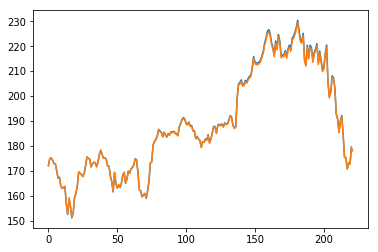

In [18]:
import keras.layers as kl
from keras.models import Model
from keras import regularizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bokeh.plotting import output_file, figure, show


class NeuralNetwork:
    def __init__(self, input_shape, stock_or_return):
        self.input_shape = input_shape
        self.stock_or_return = stock_or_return

    def make_train_model(self):
        input_data = kl.Input(shape=(1, self.input_shape))
        lstm = kl.LSTM(5, input_shape=(1, self.input_shape), return_sequences=True, activity_regularizer=regularizers.l2(0.003),
                       recurrent_regularizer=regularizers.l2(0), dropout=0.2, recurrent_dropout=0.2)(input_data)
        perc = kl.Dense(5, activation="sigmoid", activity_regularizer=regularizers.l2(0.005))(lstm)
        lstm2 = kl.LSTM(2, activity_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.001),
                        dropout=0.2, recurrent_dropout=0.2)(perc)
        out = kl.Dense(1, activation="sigmoid", activity_regularizer=regularizers.l2(0.001))(lstm2)

        model = Model(input_data, out)
        model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mse"])

        # load data

        train = np.reshape(np.array(pd.read_csv("features/autoencoded_train_data_AAPL.csv", index_col=0)),
                           (len(np.array(pd.read_csv("features/autoencoded_train_data_AAPL.csv"))), 1, self.input_shape))
        train_y = np.array(pd.read_csv("features/autoencoded_train_y_AAPL.csv", index_col=0))
        # train_stock = np.array(pd.read_csv("train_stock.csv"))

        # train model

        model.fit(train, train_y, epochs=2000)

        model.save("models/model.h5", overwrite=True, include_optimizer=True)

        test_x = np.reshape(np.array(pd.read_csv("features/autoencoded_test_data_AAPL.csv", index_col=0)),
                            (len(np.array(pd.read_csv("features/autoencoded_test_data_AAPL.csv"))), 1, self.input_shape))
        test_y = np.array(pd.read_csv("features/autoencoded_test_y_AAPL.csv", index_col=0))
        # test_stock = np.array(pd.read_csv("test_stock.csv"))

        stock_data_test = np.array(pd.read_csv("stock_data_test_AAPL.csv", index_col=0))

        print(model.evaluate(test_x, test_y))
        prediction_data = []
        stock_data = []
        for i in range(len(test_y)):
            prediction = (model.predict(np.reshape(test_x[i], (1, 1, self.input_shape))))
            prediction_data.append(np.reshape(prediction, (1,)))
            prediction_corrected = (prediction_data - np.mean(prediction_data))/np.std(prediction_data)
            stock_price = np.exp(np.reshape(prediction, (1,)))*stock_data_test[i]
            stock_data.append(stock_price[0])
        stock_data[:] = [i - (float(stock_data[0])-float(stock_data_test[0])) for i in stock_data]
        # stock_data = stock_data - stock_data[0]
        if self.stock_or_return:
            plt.plot(stock_data)
            plt.plot(stock_data_test)
            stock = pd.DataFrame(stock_data, index=None)
            stock.to_csv("sample_predictions/AAPL_predicted_prices_AAPL.csv")
            stock_test = pd.DataFrame(stock_data_test, index=None)
            stock_test.to_csv("sample_predictions/AAPL_actual_prices_AAPL.csv")
            # print(stock_data)
            plt.show()
        else:
            # plt.plot(prediction_corrected)
            plt.plot(prediction_data)
            # print(prediction_data)
            plt.plot(test_y)
            plt.show()


if __name__ == "__main__":
    model = NeuralNetwork(20, True)
model.make_train_model()

In [42]:
prediction_AAPL = pd.read_csv("sample_predictions/AAPL_predicted_prices_AAPL.csv", header=0, index_col=0)
actual_AAPL = pd.read_csv("sample_predictions/AAPL_actual_prices_AAPL.csv", header=0, index_col=0)

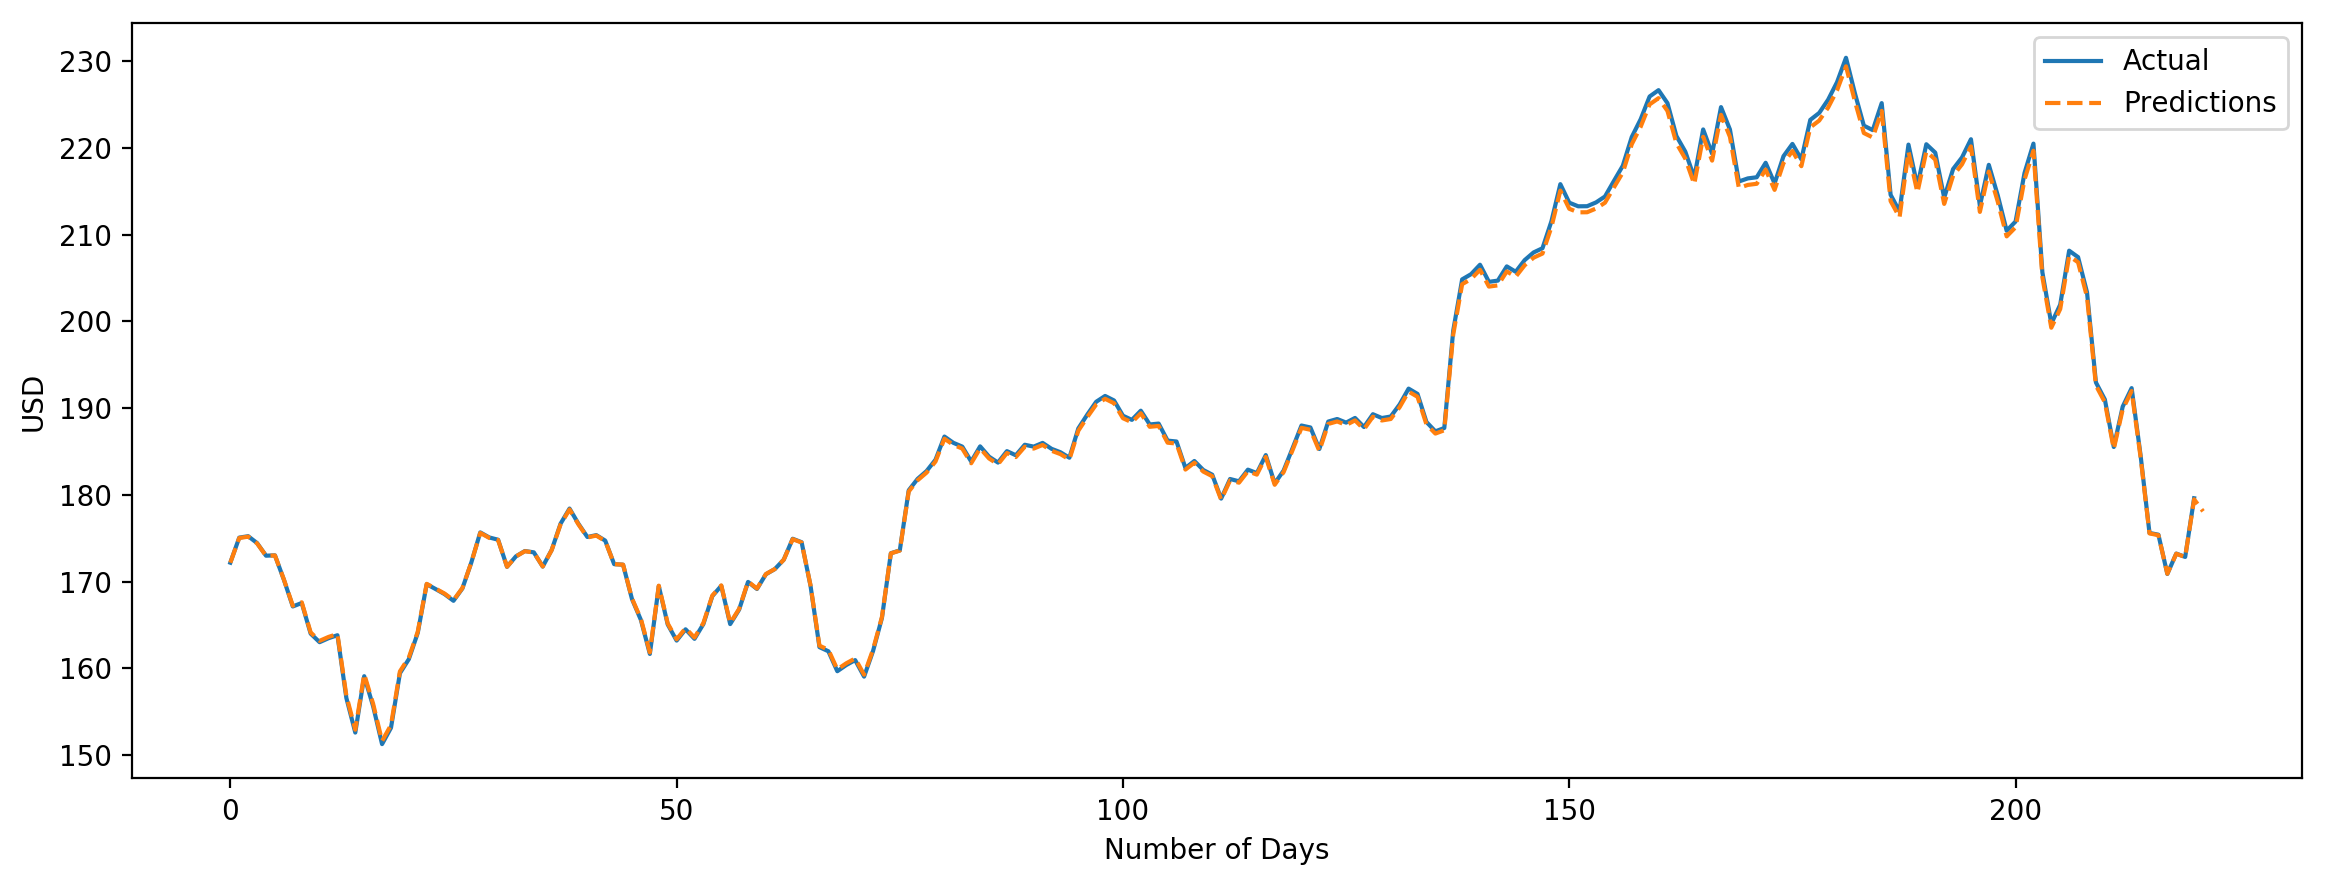

In [43]:
#plot
plt.figure(figsize=(14, 5), dpi=200)
plt.xlabel('Number of Days')
plt.ylabel('USD')
plt.plot(prediction_AAPL)
plt.plot(actual_AAPL, marker='', linestyle='dashed')
plt.legend(('Actual','Predictions'))
plt.show()

## The Above Trained Model shows better results than previously used modeling techniques as we can see from the output the plot shows the predicted values going more towards the true values